In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.optim import lr_scheduler

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 12
num_classes = 10
batch_size = 32
learning_rate = 0.001
validationRatio = 0.1

# MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())
# separating train with validation
indices = torch.randperm(len(train_dataset))
train_indices = indices[:len(indices) - int((validationRatio) * len(train_dataset))]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_indices = indices[len(indices) - int(validationRatio * len(train_dataset)):]
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, kernelNumber1, kernelNumber2, kernelNumber3 , kernelSize1, kernelSize2, kernelSize3, num_classes=10):
        super(ConvNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, kernelNumber1, kernel_size=kernelSize1, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm2d(kernelNumber1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        outputSize1 = np.floor((28-kernelSize1+2*2 + 1)/2)
        print(outputSize1)
        
        # Layer 2 
        self.conv2 = nn.Conv2d(kernelNumber1, kernelNumber2, kernel_size=kernelSize2, stride=1, padding=2)
        self.conv2_drop = nn.Dropout2d()
        self.relu2 = nn.ReLU()
        self.batchNorm2 = nn.BatchNorm2d(kernelNumber2)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        outputSize2 = np.floor((outputSize1-kernelSize2 + 2*2 + 1)/2)
        print(outputSize2)
        
        # Layer 3
        self.conv3 = nn.Conv2d(kernelNumber2, kernelNumber3, kernel_size=kernelSize3, stride=1, padding=2)
        self.conv3_drop = nn.Dropout2d()
        self.relu3 = nn.ReLU()
        self.batchNorm3 = nn.BatchNorm2d(kernelNumber3)
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        outputSize3 = np.floor((outputSize2-kernelSize3 + 2*2 + 1)/2)
        print(outputSize3)
        
        # Initialization
        self.layer1 = nn.Sequential(
            self.conv1,
            self.batchNorm1,
            self.relu1,
            self.maxPool1)
        
        self.layer2 = nn.Sequential(
            self.conv2,
            self.conv2_drop,
            self.batchNorm2,
            self.relu2,
            self.maxPool2)
        
        self.layer3 = nn.Sequential(
            self.conv3,
            self.conv3_drop,
            self.batchNorm3,
            self.relu3,
            self.maxPool3)
        self.fc1 = nn.Linear(int(outputSize3**2*kernelNumber3), int((outputSize3**2*kernelNumber3)/2))
        self.fc2 = nn.Linear(int((outputSize3**2*kernelNumber3)/2), 80)
        self.fc3 = nn.Linear(80, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
      
kernelNb1 = 32
kernelNb2 = 32
kernelNb3 = 32
kernelSize1 = 5
kernelSize2 = 5
kernelSize3 = 5
model = ConvNet(kernelNb1, kernelNb2, kernelNb3, kernelSize1, kernelSize2, kernelSize3, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
trainLoss = []
validLoss = []
validAcc = []
convol1 = []
activ1 = []
kernel1 = []
convol2 = []
activ2 = []
kernel2 = []
convol3 = []
activ3 = []
kernel3 = []
total_step = len(train_loader)
trainAcc = []
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    meanLoss = 0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        meanLoss += loss.cpu().detach().numpy()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item())) 
    trainLoss.append(meanLoss/(i+1))
    trainAcc.append(100*correct / total)
    # valid the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        meanLoss = 0
        predictions = np.zeros(1)
        valid_y = np.zeros(1)
        misclassified = np.zeros(num_classes)
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            meanLoss += loss.cpu().detach().numpy()
            
            _, predicted = torch.max(outputs.data, 1)
            predictions = np.append(predictions, predicted.cpu().detach().numpy())
            valid_y = np.append(valid_y, labels.cpu().detach().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for i,item in enumerate(predicted != labels):
              if item == 1:
                misclassified[labels[i]] += 1
        
        acc  = 100 * correct / total
        print('Validation Accuracy : {} %, Loss : {:.4f}'.format(100 * correct / total, meanLoss/len(valid_loader)))
        validLoss.append(meanLoss/len(valid_loader))
        validAcc.append(acc)
        misclassified /= (total-correct)
        print(misclassified*100)

        #saving feature map and activated feature map with kernel for each epoch
        i = 7#29
        j = 2
        # layer1
        out = model.conv1(images)
        convol1.append(out[j].cpu().detach().numpy())
        out = model.batchNorm1(out)
        out = model.relu1(out)
        activ1.append(out[j].cpu().detach().numpy())
        out = model.maxPool1(out)
        weights1 = model.conv1.weight.data.cpu().detach().numpy()
        kernel1.append(weights1)
        # layer2
        out = model.conv2(out)
        convol2.append(out[j].cpu().detach().numpy())
        out = model.batchNorm2(out)
        out = model.relu2(out)
        activ2.append(out[j].cpu().detach().numpy())
        out = model.maxPool2(out)
        weights2 = model.conv2.weight.data.cpu().detach().numpy()
        kernel2.append(weights2)
        # layer3
        out = model.conv3(out)
        convol3.append(out[j].cpu().detach().numpy())
        out = model.maxPool3(out)
        out = model.relu3(out)
        activ3.append(out[j].cpu().detach().numpy())
        weights3 = model.conv3.weight.data.cpu().detach().numpy()
        kernel3.append(weights3)

predictions = predictions[1:]
valid_y = valid_y[1:]

# Test set
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    meanLoss = 0
    misclassified = np.zeros(num_classes)
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        meanLoss += loss.cpu().detach().numpy()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i,item in enumerate(predicted != labels):
          if item == 1:
            misclassified[labels[i]] += 1

    acc  = 100 * correct / total
    print('Test Accuracy : {} %, Loss : {:.4f}'.format(100 * correct / total, meanLoss/len(test_loader)))
    misclassified /= (total-correct)
    #print(misclassified*100)
        
# Save the model checkpoint        
torch.save(model.state_dict(), 'model.ckpt')



14.0
7.0
3.0
Epoch [1/12], Step [100/1688], Loss: 0.7211
Epoch [1/12], Step [200/1688], Loss: 0.6472
Epoch [1/12], Step [300/1688], Loss: 0.6505
Epoch [1/12], Step [400/1688], Loss: 0.5791
Epoch [1/12], Step [500/1688], Loss: 0.7036
Epoch [1/12], Step [600/1688], Loss: 0.4497
Epoch [1/12], Step [700/1688], Loss: 0.3323
Epoch [1/12], Step [800/1688], Loss: 0.7002
Epoch [1/12], Step [900/1688], Loss: 0.5051
Epoch [1/12], Step [1000/1688], Loss: 0.6002
Epoch [1/12], Step [1100/1688], Loss: 0.2577
Epoch [1/12], Step [1200/1688], Loss: 0.6326
Epoch [1/12], Step [1300/1688], Loss: 0.8369
Epoch [1/12], Step [1400/1688], Loss: 0.5807
Epoch [1/12], Step [1500/1688], Loss: 0.4568
Epoch [1/12], Step [1600/1688], Loss: 0.3805
Validation Accuracy : 85.6 %, Loss : 0.4043
[12.5         3.58796296 10.30092593  7.87037037 11.11111111  9.375
 35.99537037  1.62037037  2.77777778  4.86111111]
Epoch [2/12], Step [100/1688], Loss: 0.5146
Epoch [2/12], Step [200/1688], Loss: 0.2794
Epoch [2/12], Step [300/16

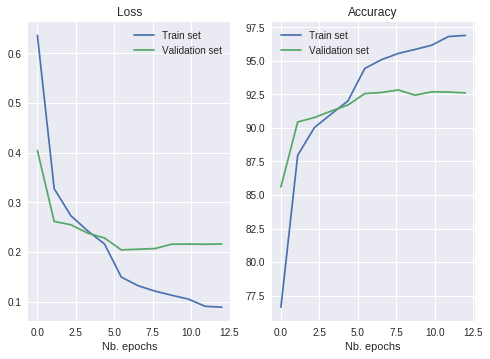

In [0]:
import matplotlib.pyplot as plt

x = np.linspace(0,num_epochs,num_epochs)
plt.subplot(1,2,1)
plt.plot(x,trainLoss)
plt.plot(x,validLoss)
plt.title('Loss')
plt.xlabel('Nb. epochs')
plt.legend(('Train set','Validation set'))

plt.subplot(1,2,2)
plt.plot(x,trainAcc)
plt.plot(x,validAcc)
plt.title('Accuracy')
plt.xlabel('Nb. epochs')
plt.legend(("Train set", "Validation set"))

plt.show()
fig = plt.gcf()
fig.set_size_inches(12, 12)

In [0]:
# Saving output

mat = np.matrix(trainLoss)
with open('trainloss.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')
        
mat = np.matrix(validLoss)
with open('validloss.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')

mat = np.matrix(validAcc)
with open('validAcc.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')

mat = np.matrix(trainAcc)
with open('trainAcc.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')

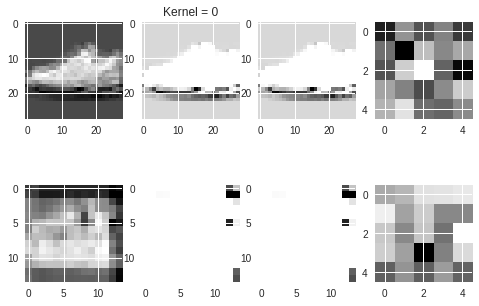

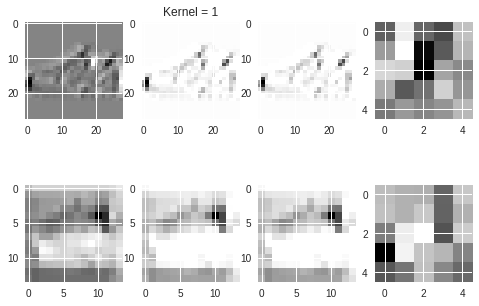

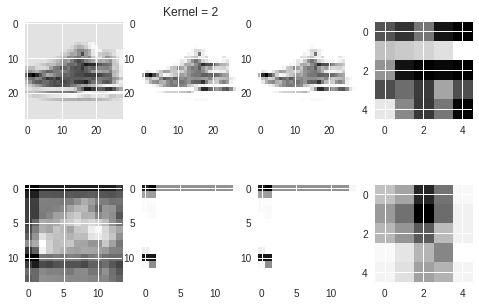

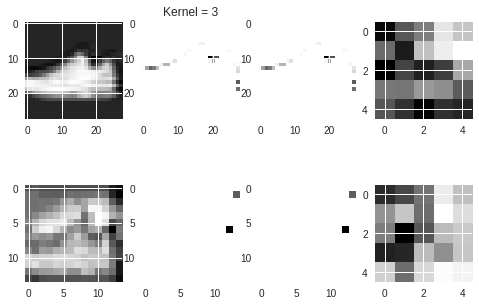

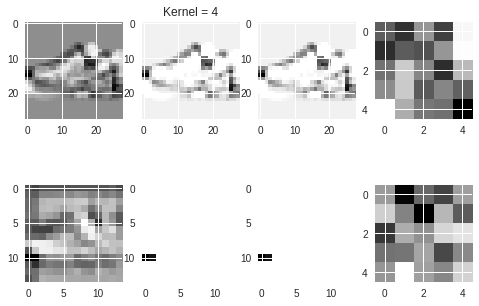

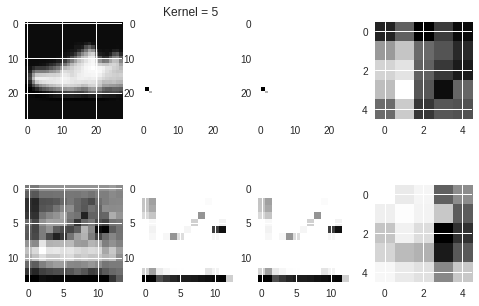

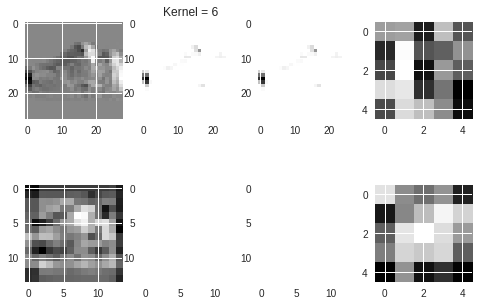

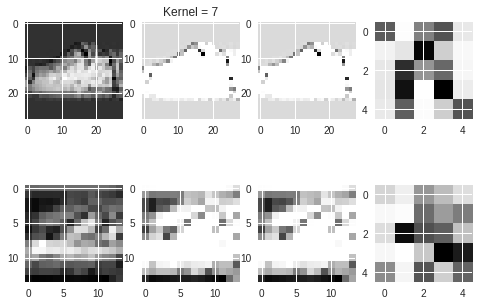

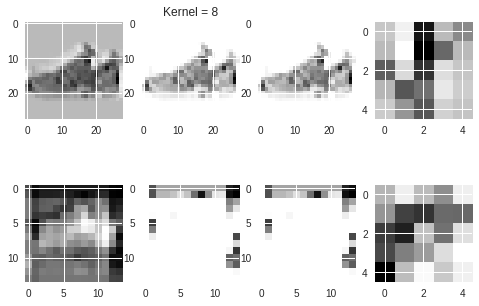

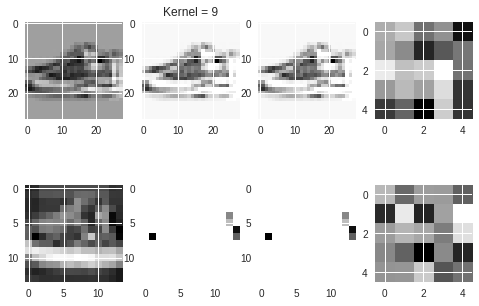

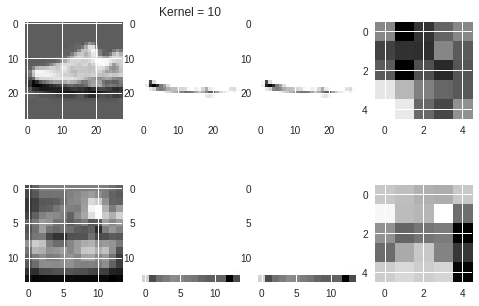

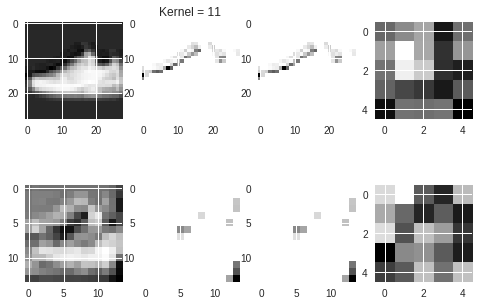

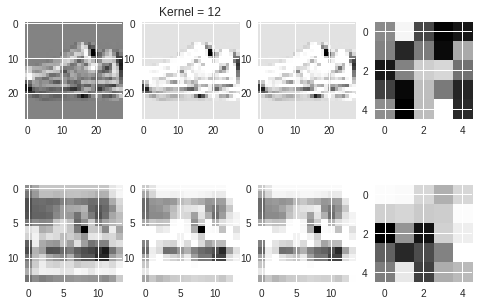

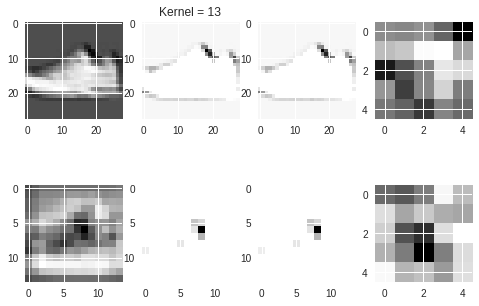

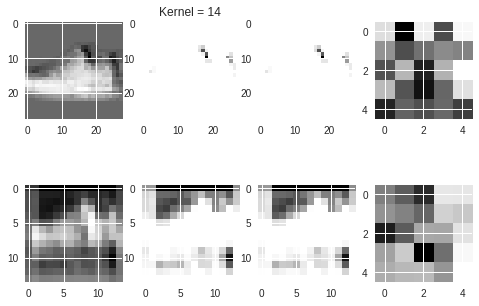

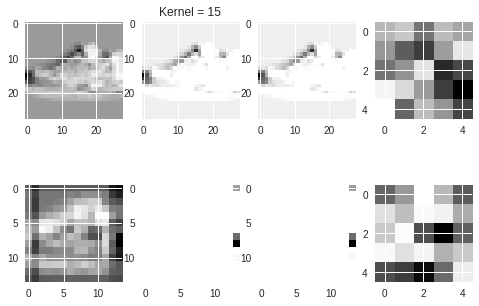

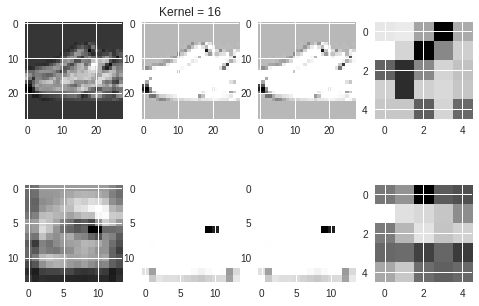

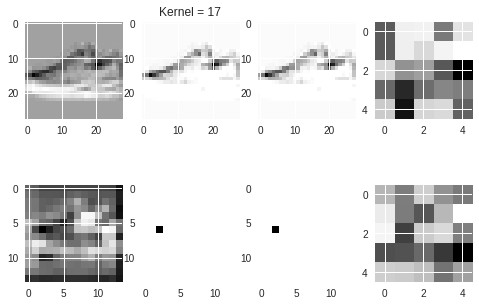

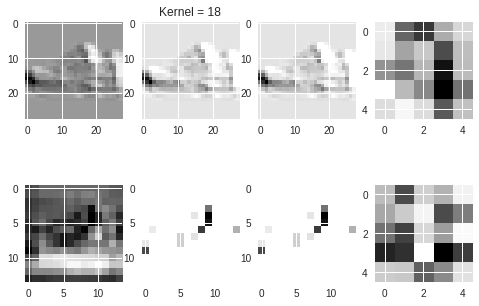

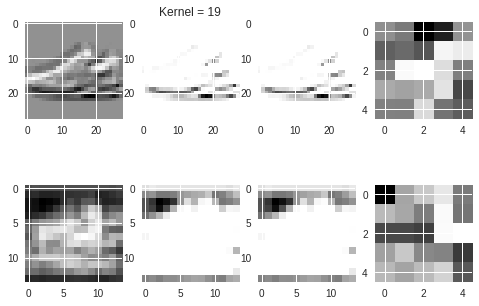

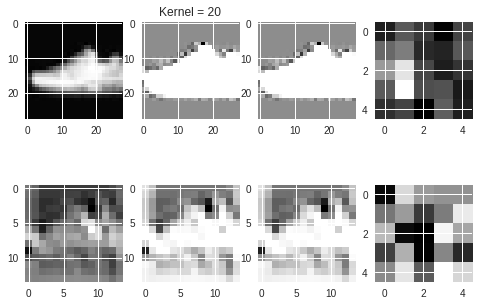

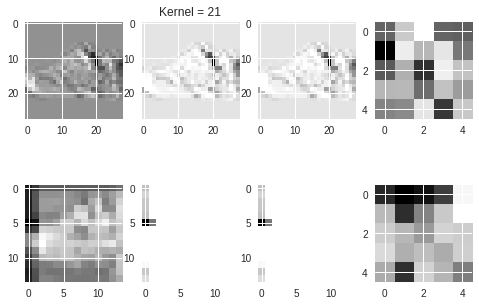

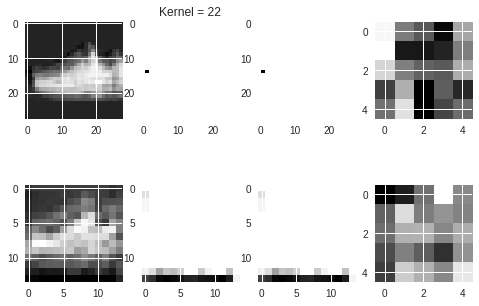

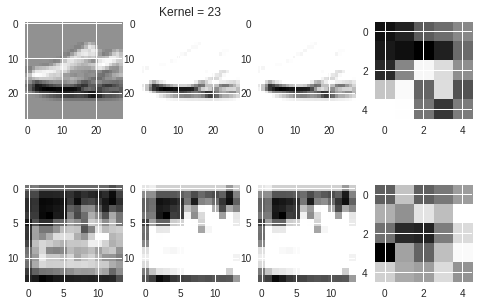

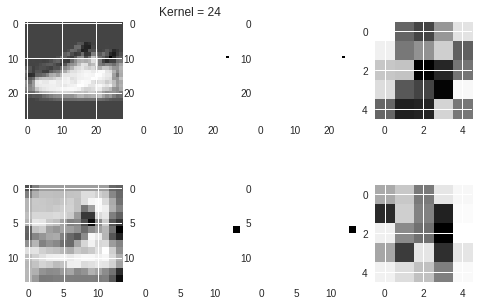

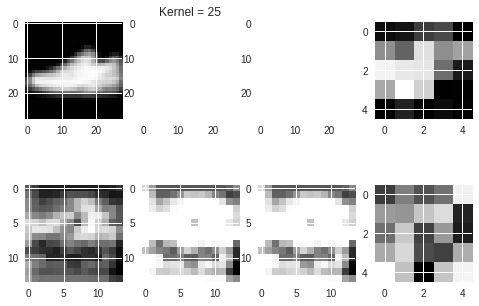

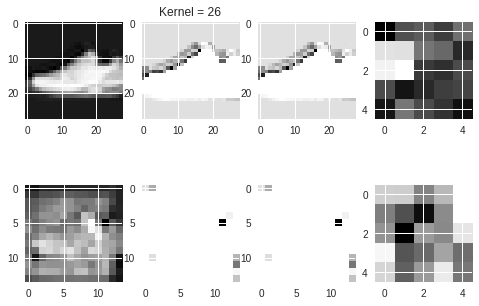

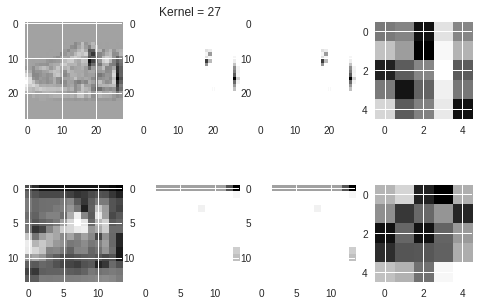

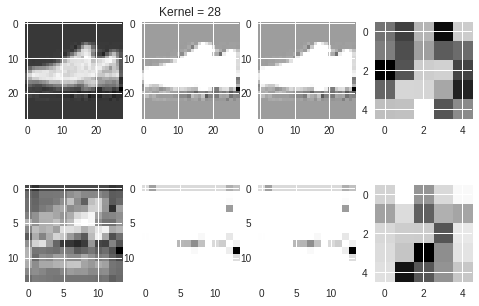

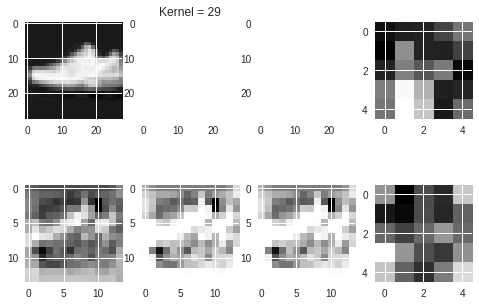

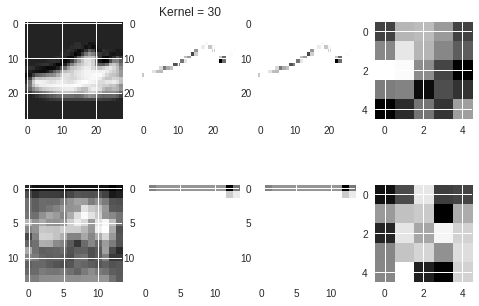

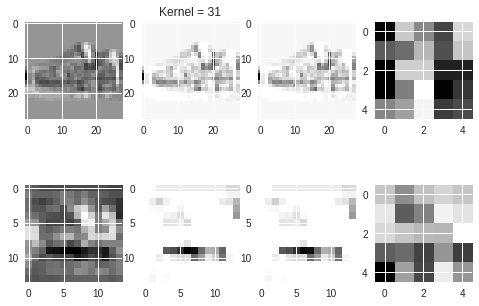

In [0]:
# Visualisation of all kernels and feature maps for the two first layers

# Choosing image
j = 2
model.cuda()
# Choosing kernel 
for i in range(0, 32):
  # Layer 1 
  out = model.conv1(images.to(device))
  #print(out[j][i].shape)
  plt.subplot2grid((2,4),(0,0))
  plt.imshow(out[j][i].cpu().detach().numpy())

  out = model.relu1(out)
  #print(out[j][i].shape)
  plt.subplot2grid((2,4),(0,1))
  plt.imshow(out[j][i].cpu().detach().numpy())
  title = 'Kernel = ' + str(i)
  plt.title(title)


  out = model.batchNorm1(out)
  plt.subplot2grid((2,4),(0,2))
  #print(out[j][i].shape)
  plt.imshow(out[j][i].cpu().detach().numpy())
  
  plt.subplot2grid((2,4),(0,3))
  weightsLayer1 = model.conv1.weight.data.cpu().detach().numpy()
  plt.imshow(weightsLayer1[i][0])
  
  out = model.maxPool1(out)
  #print(out[j][i].shape)
  #plt.imshow(out[j][i].cpu().detach().numpy())
  #plt.show()

  # Layer 2 
  out = model.conv2(out)
  #print(out[j][i].shape)
  plt.subplot2grid((2,4),(1,0))
  plt.imshow(out[j][i].cpu().detach().numpy())


  out = model.relu2(out)
  #print(out[j][i].shape)
  plt.subplot2grid((2,4),(1,1))
  plt.imshow(out[j][i].cpu().detach().numpy())


  out = model.batchNorm2(out)
  plt.subplot2grid((2,4),(1,2))
  #print(out[j][i].shape)
  plt.imshow(out[j][i].cpu().detach().numpy())


  out = model.maxPool2(out)
  #print(out[j][i].shape)
  #plt.imshow(out[j][i].cpu().detach().numpy())
  
  plt.subplot2grid((2,4),(1,3))
  weightsLayer1 = model.conv2.weight.data.cpu().detach().numpy()
  plt.imshow(weightsLayer1[i][0])
  
  plt.show()

In [0]:
weightsLayer1 = model.conv1.weight.data.cpu().detach().numpy()
print(weightsLayer1[0][0].shape)
print(weightsLayer1[0][0])
for i in range(0,weightsLayer1.shape[0]):
  plt.imshow(weightsLayer1[i][0])
  plt.show()

In [0]:
weightsLayer1 = model.conv2.weight.data.cpu().detach().numpy()
print(weightsLayer1[0][0].shape)
print(weightsLayer1[0][0])
for i in range(0,weightsLayer1.shape[0]):
  plt.imshow(weightsLayer1[i][0])
  plt.show()

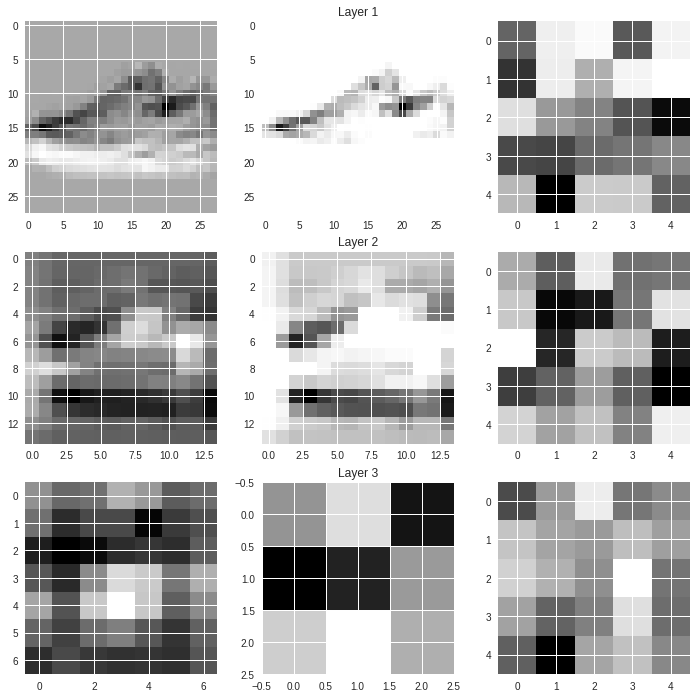

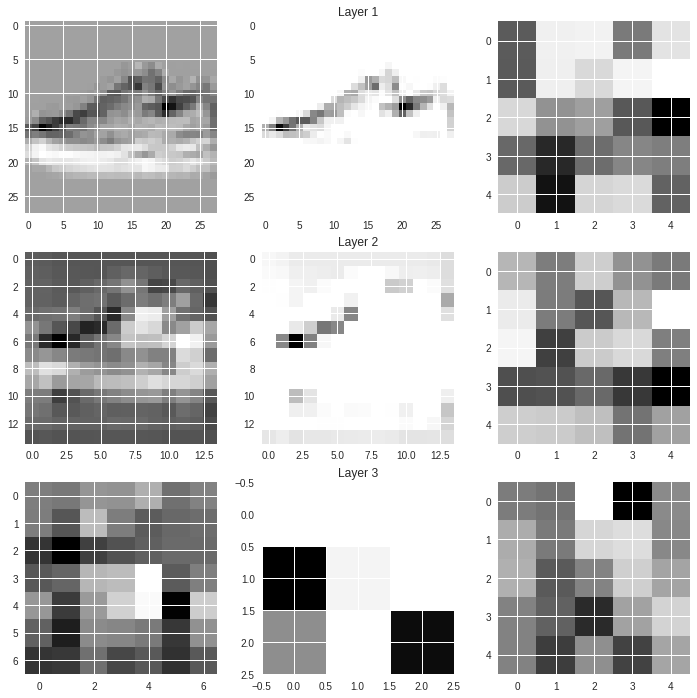

In [0]:
#plot all filters and activation maps for each epoch
j = 17 # filter 2.. 3 4(contour), 6(flou) 17
for i in [0,9]:#range(len(convol1)):
  # layer 1
  plt.subplot2grid((3,3),(0,0))
  plt.imshow(convol1[i][j]*255)
  
  plt.subplot2grid((3,3),(0,1))
  plt.imshow(activ1[i][j]*255)
  plt.title('Layer 1')

  plt.subplot2grid((3,3),(0,2))
  plt.imshow(kernel1[i][j][0])
  #plt.show()
  
  # layer 2
  plt.subplot2grid((3,3),(1,0))
  plt.imshow(convol2[i][j]*255)
  
  plt.subplot2grid((3,3),(1,1))
  plt.imshow(activ2[i][j]*255)
  plt.title('Layer 2')
  
  plt.subplot2grid((3,3),(1,2))
  plt.imshow(kernel2[i][j][0]*255)
  #plt.show()
  
  # layer 3
  plt.subplot2grid((3,3),(2,0))
  plt.imshow(convol3[i][j]*255)
  
  plt.subplot2grid((3,3),(2,1))
  plt.imshow(activ3[i][j]*255)
  plt.title('Layer 3')
  
  plt.subplot2grid((3,3),(2,2))
  plt.imshow(kernel3[i][j][0]*255)
  fig = plt.gcf()
  fig.set_size_inches(12, 12)
  plt.show()
  


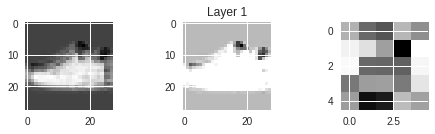

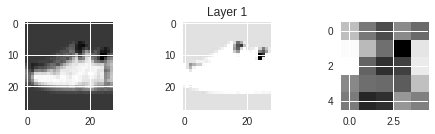

In [0]:
# plot most interesting figures
for i in [0,9]:
  # layer 1
  plt.subplot2grid((3,3),(0,0))
  plt.imshow(convol1[i]*255)
  
  plt.subplot2grid((3,3),(0,1))
  plt.imshow(activ1[i]*255)
  plt.title('Layer 1')
  
  plt.subplot2grid((3,3),(0,2))
  plt.imshow(kernel1[i]*255)
  plt.show()

In [0]:
# def train function

def train(train_loader, valid_loader):
  
  # Train the model
  trainLoss = []
  validLoss = []
  validAcc = []
  convol1 = []
  activ1 = []
  kernel1 = []
  convol2 = []
  activ2 = []
  kernel2 = []
  convol3 = []
  activ3 = []
  kernel3 = []
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      exp_lr_scheduler.step()
      meanLoss = 0
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          meanLoss += loss.cpu().detach().numpy()
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

#           if (i+1) % 100 == 0:
#               print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                      .format(epoch+1, num_epochs, i+1, total_step, loss.item())) 
      trainLoss.append(meanLoss/(i+1))

      # valid the model
      model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
      with torch.no_grad():
          correct = 0
          total = 0
          meanLoss = 0
          predictions = np.zeros(1)
          valid_y = np.zeros(1)
          misclassified = np.zeros(num_classes)
          for images, labels in valid_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              meanLoss += loss.cpu().detach().numpy()
              _, predicted = torch.max(outputs.data, 1)
              predictions = np.append(predictions, predicted.cpu().detach().numpy())
              valid_y = np.append(valid_y, labels.cpu().detach().numpy())
  predictions = predictions[1:]
  valid_y = valid_y[1:]
  return predictions, valid_y             

In [0]:
# create confusion matrix over 10 trainings
from sklearn.metrics import confusion_matrix

cm = np.zeros((10,10))
for i in range(10):
  print('Currently on run #')
  print(i)
  predictions, valid_y = train(train_loader, valid_loader)
  cm += confusion_matrix(valid_y, predictions) / 10

0
1
2
3
4
5
6
7
8
9


In [0]:
# Saving confusion matrix matix
mat = np.matrix(cm)
with open('outfile.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%.2f')

In [0]:
# PLot confusion matrix

import itertools
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure()
plot_confusion_matrix(cm.astype(np.int64), classes=classes)

plt.savefig("./confusion_matrix.png")